## Data Load

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

<AxesSubplot:xlabel='time'>

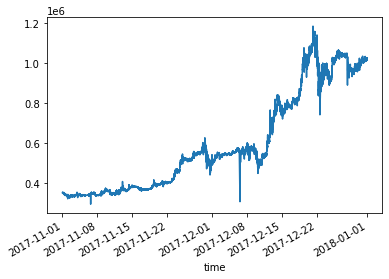

In [2]:
# 데이터 경로
DATA_PATH = '/aiffel/aiffel/fnguide/data/'

# 데이터 불러오기
modify_data = pd.read_csv(os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv'), index_col=0, parse_dates=True)

# 불러온 데이터 시각화하기
modify_data.loc['2017-11-01':'2017-12-31','close'].plot()

## 1. Data Labeling

### 1.1 Price Change Direction

In [4]:
# window 지정
window = 10

# momentum_signal 만들기
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].shift(window)) + 1)

# s_momentum_signal 만들기
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

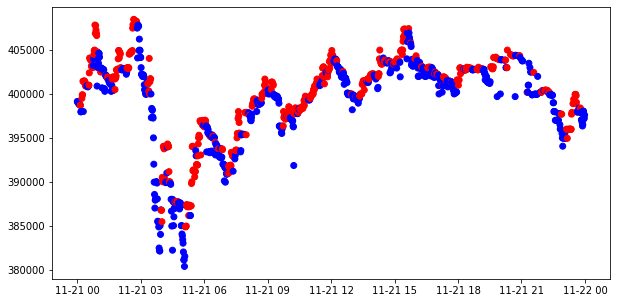

In [5]:
# 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize=(10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1.2 Using Moving Average

In [7]:
# momentum_signal 
momentum_signal = np.sign(np.sign(modify_data['close'] - modify_data['close'].rolling(window).mean()) + 1)

# s_momentum_signal
s_momentum_signal = pd.Series(momentum_signal, index=modify_data.index)

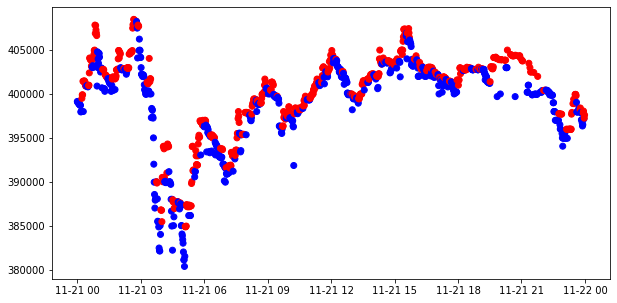

In [8]:
 # 기존 데이터 만들기
sub_data = modify_data.loc['2017-11-21', 'close']

# 수식 적용된 데이터 만들기
c_sig = s_momentum_signal.loc['2017-11-21']

# 두 데이터의 비교를 위한 색상 바꾸기
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

# 시각화하기
plt.figure(figsize = (10,5))
plt.scatter(sub_data.index, sub_data, c=c_sig['color'])

### 1.3 Local Min-Max 

In [13]:
# Local min / max 를 추출하기 위한 함수
def get_local_min_max(close, wait=3):
    min_value = close.iloc[0]
    max_value = close.iloc[0]
    n_cnt_min, n_cnt_max = 0, 0
    
    mins, maxes = [], []
    min_idxes, max_idxes = [], []
    b_min_update, b_max_update = False, False
    
    for idx, val in zip(close.index[1:], close.values[1:]):
        if val < min_value:
            min_value = val
            mins.append(min_value)
            min_idxes.append(idx)
            n_cnt_min = 0
            b_min_update = True
        if val > max_value:
            max_value = val
            maxes.append(max_value)
            max_idxes.append(idx)
            n_cnt_max = 0
            b_max_update = True
        
        if not b_max_update:
            b_min_update = False
            n_cnt_min += 1
            if n_cnt_min >= wait:
                max_value = min_value
                n_cnt_min = 0
    
        if not b_min_update:
            b_max_update = False
            n_cnt_max += 1
            if n_cnt_max >= wait:
                min_value = max_value
                n_cnt_max = 0
               
    return pd.DataFrame.from_dict({'min_time': min_idxes, 'local_min': mins}), pd.DataFrame.from_dict({'max_time': max_idxes, 'local_max': maxes})

In [14]:
# Local mins, maxes를 확인
mins, maxes = get_local_min_max(sub_data, wait=3)

# mins, maxes 확인 
print(mins)
print('--'*20)
print(maxes)

               min_time  local_min
0   2017-11-21 00:01:00     399050
1   2017-11-21 00:03:00     399000
2   2017-11-21 00:04:00     398900
3   2017-11-21 00:05:00     398850
4   2017-11-21 00:06:00     398800
..                  ...        ...
472 2017-11-21 23:48:00     397850
473 2017-11-21 23:50:00     397050
474 2017-11-21 23:52:00     396750
475 2017-11-21 23:53:00     396350
476 2017-11-21 23:59:00     397600

[477 rows x 2 columns]
----------------------------------------
               max_time  local_max
0   2017-11-21 00:13:00     399500
1   2017-11-21 00:14:00     399900
2   2017-11-21 00:16:00     401450
3   2017-11-21 00:19:00     401350
4   2017-11-21 00:20:00     401500
..                  ...        ...
268 2017-11-21 23:41:00     398050
269 2017-11-21 23:43:00     398400
270 2017-11-21 23:46:00     398200
271 2017-11-21 23:47:00     398400
272 2017-11-21 23:56:00     398050

[273 rows x 2 columns]


(376546.5, 412585.0)

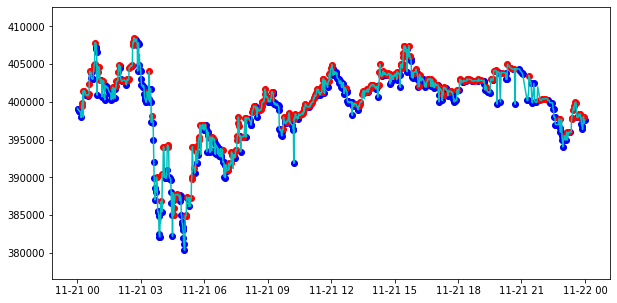

In [15]:
# subplots 및 plot 생성
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(sub_data, 'c')

# min_time, local_min을 활용한 scatter plot 생성
ax.scatter(mins.min_time, mins.local_min, c='blue')

# maxes_time, local_max를 활용한 scatter plot 생성
ax.scatter(maxes.max_time, maxes.local_max, c='red')

# y축 설정
ax.set_ylim([sub_data.min() * 0.99, sub_data.max()  * 1.01])

### 1.4 Trend Scanning

In [17]:
def t_val_lin_r(close):
    import statsmodels.api as sml
    
    # t-value from a linear trend
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sml.OLS(close, x).fit() 
    return ols.tvalues[1]

In [18]:
look_forward_window = 60
min_sample_length = 5
step = 1
t1_array = []
t_values_array = []

In [19]:
molecule = modify_data['2017-11-01':'2017-11-30'].index
label = pd.DataFrame(index=molecule, columns=['t1', 't_val', 'bin'])
tmp_out = []

for ind in tqdm(molecule):
    subset = modify_data.loc[ind:, 'close'].iloc[:look_forward_window]  # 전방 탐색을 위한 샘플 추출
    if look_forward_window > subset.shape[0]:
        continue
    
    tmp_subset = pd.Series(index=subset.index[min_sample_length-1:subset.shape[0]-1])
    tval = []

    # 회귀분석을 통해 t 통계량값을 이용하여 추세 추정
    for forward_window in np.arange(min_sample_length, subset.shape[0]):
        df = subset.iloc[:forward_window]
        tval.append(t_val_lin_r(df.values))  # t-value 사용
    
    tmp_subset.loc[tmp_subset.index] = np.array(tval)
    idx_max = tmp_subset.replace([-np.inf, np.inf, np.nan], 0).abs().idxmax()
    tmp_t_val = tmp_subset[idx_max]
    tmp_out.append([tmp_subset.index[-1], tmp_t_val, np.sign(tmp_t_val)])

label.loc[molecule] = np.array(tmp_out)  # prevent leakage

label['t1'] = pd.to_datetime(label['t1'])
label['bin'] = pd.to_numeric(label['bin'], downcast='signed')

100%|██████████| 33384/33384 [13:57<00:00, 39.86it/s]


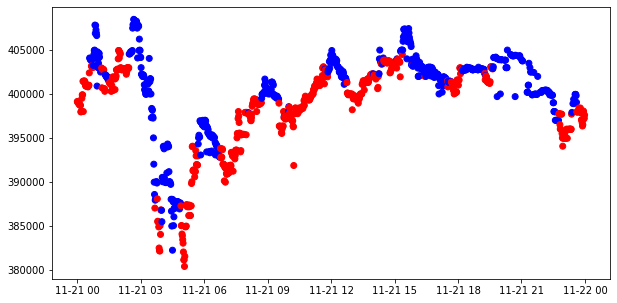

In [22]:
# 시각화
sub_data = modify_data.loc['2017-11-21', 'close']
c_sig = label['bin'].loc['2017-11-21']
c_sig['color'] = np.where(c_sig == 1, 'red', 'blue')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(sub_data.index, sub_data.values, c=c_sig['color'])

##  2. Feature Engineering

In [23]:
!pip install ta==0.9.0
!pip install shap

In [24]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

import sys
sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.feature_importance import importance as imp
from sklearn.feature_selection import SequentialFeatureSelector, RFECV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [25]:
# 데이터 경로 설정
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
anno_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick_label.pkl')
target_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_tick.csv')

# 데이터 불러오기
df_modify_data = pd.read_csv(target_file_name, index_col=0, parse_dates=True)
df_label_data = pd.read_pickle(anno_file_name)
df_sub_modify_data = df_modify_data.loc[df_label_data.index]

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
df_sub_modify_data = df_sub_modify_data.iloc[:1000]

### 2.1 Technical Index

In [26]:
mt = 1
fillna = False
df_ = df_sub_modify_data.copy()
open, high, low, close, volume = 'open', 'high', 'low', 'close', 'volume'
cols = [open, high, low, close, volume]

## Volume Index
# Chaikin Money Flow
df_["volume_cmf"] = ta.volume.ChaikinMoneyFlowIndicator(
                        high=df_[high], low=df_[low], close=df_[close], volume=df_[volume], window=20*mt, fillna=fillna
                    ).chaikin_money_flow()
# Force Index
df_["volume_fi"] = ta.volume.ForceIndexIndicator(
                        close=df_[close], volume=df_[volume], window=15*mt, fillna=fillna
                    ).force_index()
# Money Flow Indicator
df_["volume_mfi"] = ta.volume.MFIIndicator(
                        high=df_[high],
                        low=df_[low],
                        close=df_[close],
                        volume=df_[volume],
                        window=15*mt,
                        fillna=fillna,
                    ).money_flow_index()
# Ease of Movement
df_["volume_sma_em"] = ta.volume.EaseOfMovementIndicator(
                            high=df_[high], low=df_[low], volume=df_[volume], window=15*mt, fillna=fillna
                        ).sma_ease_of_movement()

# Volume Price Trend
df_["volume_vpt"] = ta.volume.VolumePriceTrendIndicator(
                        close=df_[close], volume=df_[volume], fillna=fillna
                    ).volume_price_trend()

## volatility index
# Average True Range
df_["volatility_atr"] = ta.volatility.AverageTrueRange(
                            close=df_[close], high=df_[high], low=df_[low], window=10*mt, fillna=fillna
                        ).average_true_range()

# Ulcer Index
df_["volatility_ui"] = ta.volatility.UlcerIndex(
                            close=df_[close], window=15*mt, fillna=fillna
                        ).ulcer_index()

## trend index
# MACD
df_["trend_macd_diff"] = ta.trend.MACD(
                            close=df_[close], window_slow=25*mt, window_fast=10*mt, window_sign=9, fillna=fillna
                        ).macd_diff()

# Average Directional Movement Index (ADX)
df_["trend_adx"] = ta.trend.ADXIndicator(
                        high=df_[high], low=df_[low], close=df_[close], window=15*mt, fillna=fillna
                    ).adx()

# TRIX Indicator
df_["trend_trix"] = ta.trend.TRIXIndicator(
                        close=df_[close], window=15*mt, fillna=fillna
                    ).trix()

# Mass Index
df_["trend_mass_index"] = ta.trend.MassIndex(
                            high=df_[high], low=df_[low], window_fast=10*mt, window_slow=25*mt, fillna=fillna
                        ).mass_index()

# DPO Indicator
df_["trend_dpo"] = ta.trend.DPOIndicator(
                        close=df_[close], window=20*mt, fillna=fillna
                    ).dpo()

# Aroon Indicator
df_["trend_aroon_ind"] = ta.trend.AroonIndicator(close=df_[close], window=20, fillna=fillna).aroon_indicator()

## momentum index
# Relative Strength Index (RSI)
df_["momentum_rsi"] = ta.momentum.RSIIndicator(close=df_[close], window=15*mt, fillna=fillna).rsi()

# Williams R Indicator
df_["momentum_wr"] = ta.momentum.WilliamsRIndicator(
                        high=df_[high], low=df_[low], close=df_[close], lbp=15*mt, fillna=fillna
                    ).williams_r()

In [27]:
# 수익률 / 변동성 지표 적용
windows_mom = [5, 10, 20]
windows_std = [30]

for i in windows_mom:
    df_[f'vol_change_{i}'] = df_.volume.pct_change(i).round(6)
    df_[f'ret_{i}'] = df_.close.pct_change(i).round(6)

for i in windows_std:
    df_[f'std_{i}'] = df_.close.rolling(i).std()
    df_[f'vol_std_{i}'] = df_.volume.rolling(i).std()

In [64]:
df_tmp_data = df_.join(df_label_data).dropna()

# X, y 데이터셋 만들기
X = df_tmp_data.iloc[:, 5:-1] 
y = df_tmp_data.iloc[:, -1] 

# StandardScaler 적용
sc = StandardScaler()

# fit_transform 사용
X_sc = sc.fit_transform(X)

# DataFrame 변환
X_sc = pd.DataFrame(X_sc, index=X.index, columns=X.columns)

In [65]:
# RandomForest 모델 적용
rfc = RandomForestClassifier(class_weight='balanced')

# RandomForest fit 하기
rfc.fit(X_sc, y)

RandomForestClassifier(class_weight='balanced')

###  2.2 Feature Selection methods

In [66]:
# MDI, Mean Decrease Impurity 
feat_imp = imp.mean_decrease_impurity(rfc, X.columns)
feat_imp

,mean,std
volume_cmf,0.047527,0.002083
volume_fi,0.045274,0.002444
volume_mfi,0.045250,0.002632
volume_sma_em,0.035983,0.002018
volume_vpt,0.023797,0.001511
volatility_atr,0.084559,0.003576
volatility_ui,0.045554,0.002185
trend_macd_diff,0.075198,0.003906
trend_adx,0.055754,0.002708
trend_trix,0.069942,0.002744


In [67]:
# MDA, Mean Decrease Accuracy
svc_rbf = SVC(kernel='rbf', probability=True) 
cv = KFold(n_splits=5) 
feat_imp_mda = imp.mean_decrease_accuracy(svc_rbf, X_sc, y, cv_gen=cv)

In [34]:
# plot_feature_importance 함수 만들기
def plot_feature_importance(importance_df, save_fig=False, output_path=None):
    # Plot mean imp bars with std
    plt.figure(figsize=(10, importance_df.shape[0] / 5))
    importance_df.sort_values('mean', ascending=True, inplace=True)
    importance_df['mean'].plot(kind='barh', color='b', alpha=0.25, xerr=importance_df['std'], error_kw={'ecolor': 'r'})
    if save_fig:
        plt.savefig(output_path) 
    else:
        plt.show()

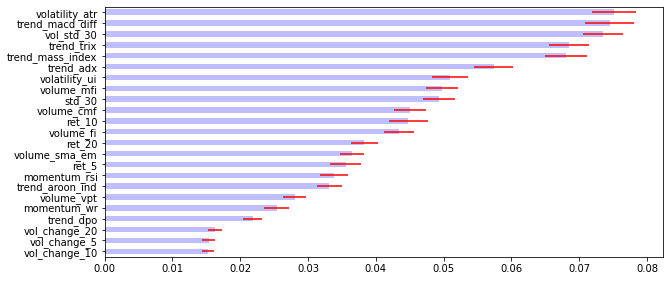

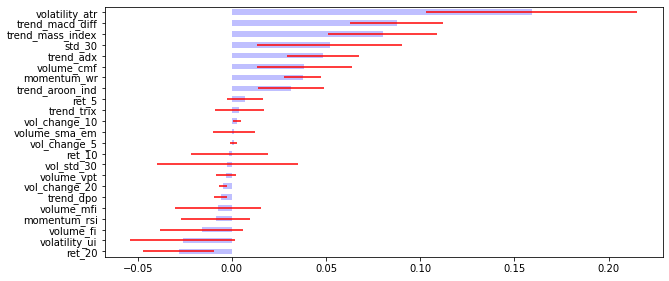

In [35]:
# feat_imp 확인
plot_feature_importance(feat_imp)

# feat_imp_mda 확인
plot_feature_importance(feat_imp_mda)

In [36]:
# RFE CV, Recursive Feature Elimination
svc_rbf = SVC(kernel='linear', probability=True) 
rfe_cv = RFECV(svc_rbf, cv=cv)
rfe_fitted = rfe_cv.fit(X_sc, y)

In [37]:
# SFS, Sequential Feature Selection
sfs_forward = SequentialFeatureSelector(svc_rbf, n_features_to_select=2, direction='forward')
sfs_fitted = sfs_forward.fit(X_sc, y)

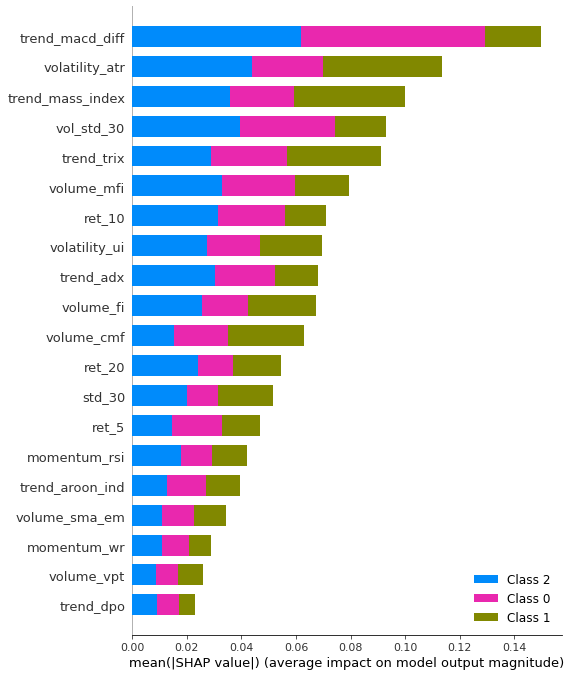

In [38]:
# SHAP, Shapley Additive explanations
import shap
explainer = shap.TreeExplainer(rfc)
shap_value = explainer.shap_values(X_sc)

# shap_value, X_sc 사용 shap.summary_plot 그리기
shap.summary_plot(shap_value, X_sc)

## 3. Model Traning

In [39]:
import datetime
import sys
import os
import re
import io
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, roc_curve

sys.path.append('/aiffel/aiffel/fnguide/data/')
from libs.mlutil.pkfold import PKFold

In [43]:
# 데이터 경로 설정 및 pickle 파일 불러오기
DATA_PATH = '/aiffel/aiffel/fnguide/data/'
data_file_name = os.path.join(DATA_PATH, 'sub_upbit_eth_min_feature_labels.pkl')

df_data = pd.read_pickle(data_file_name)
df_data['t_value'] = df_data['t_value'].apply(lambda x: x if x == 1 else 0)

In [45]:
# 여기서부터 모델에 적용하기 위한 데이터 정제화를 시작합니다.
df_data['t_value'].value_counts()

1.0    481
0.0    476
Name: t_value, dtype: int64

In [44]:
# 데이터셋 비율 나누기
train_ratio, test_ratio = 0.7, 0.2
n_train = int(np.round(len(df_data) * train_ratio))
n_test = int(np.round(len(df_data) * test_ratio))

X, y = df_data.iloc[:, 5:-1], df_data.iloc[:, -1]

# standardzation
sc = StandardScaler()
X_sc = sc.fit_transform(X)

# 데이터셋 분리
train_x, test_x, train_y, test_y = X_sc[:n_train, :], X_sc[-n_test:, :], y.iloc[:n_train], y.iloc[-n_test:]

train_x = pd.DataFrame(train_x, index=train_y.index, columns=X.columns)
train_y = pd.Series(train_y, index=train_y.index)
test_x = pd.DataFrame(test_x, index=test_y.index, columns=X.columns)
test_y = pd.Series(test_y, index=test_y.index)

# 학습 시간 단축을 위해 여기선 편의상 1000개의 데이터만 가져옵니다.
train_x = train_x[:1000] # 데이터셋을 증가 혹은 감소시켜 결과를 비교해봅시다.
train_y = train_y[:1000]

### 3.1 Purged K-fold for Cross-Validation

In [46]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

### 3.2 Find the best param for bagging(RandomForest) with grid-search

In [47]:
bc_params = {'n_estimators': [5, 10, 20],
             'max_features': [0.5, 0.7],
             'base_estimator__max_depth': [3,5,10,20],
             'base_estimator__max_features': [None, 'auto'],
             'base_estimator__min_samples_leaf': [3, 5, 10],
             'bootstrap_features': [False, True]
            }
            
# RandomForest 사용
rfc = RandomForestClassifier(class_weight='balanced')

# Bagging 적용
bag_rfc = BaggingClassifier(rfc)

# GridSearchCV 적용
gs_rfc = GridSearchCV(bag_rfc, bc_params, cv=cv, n_jobs=-1, verbose=1)

# fit
gs_rfc.fit(train_x, train_y)

# best estimator 
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 288 candidates, totalling 1152 fits


In [55]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [56]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[80 56]
 [12 43]]
정확도:0.643979057591623, 정밀도:0.43434343434343436, 재현율:0.7818181818181819


auc:0.6850267379679145


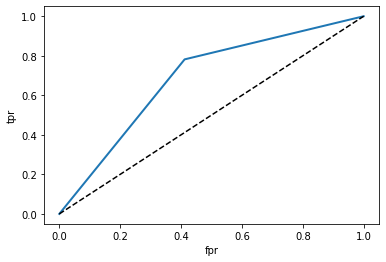

In [57]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 3.3 Attempt with RandomForest model without Bagging

In [91]:
n_cv = 4
t1 = pd.Series(train_y.index.values, index=train_y.index)

# purged K-Fold 
cv = PKFold(n_cv, t1, 0)

In [92]:
# 적절한 파라미터 설정
rf_params = {
    'n_estimators': [5, 10, 20],  
    'max_features': [0.5, 0.7],  
    'max_depth': [3, 5, 10, 20],  
    'min_samples_leaf': [3, 5, 10],  
}

# RandomForestClassifier 인스턴스 생성, class_weight='balanced' 추가
rfc = RandomForestClassifier(class_weight='balanced')

# GridSearchCV 적용
gs_rfc = GridSearchCV(rfc, rf_params, cv=cv, n_jobs=-1, verbose=2)

# 학습 데이터로 모델 학습
gs_rfc.fit(train_x, train_y)

# 최적의 추정기
gs_rfc_best = gs_rfc.best_estimator_

Fitting 4 folds for each of 72 candidates, totalling 288 fits
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=0.5, min_samples_leaf=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=0.7, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=0.7, min_samples_leaf=5, n_estimators=20; total time=   0.1s
[CV] END max_depth=10, max_features=0.7, min_samples_leaf=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=0.7, min_samples_leaf=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=10, max_features=0.7, min_samples_leaf=10, n_e

In [93]:
# 예측값 확인
pred_y = gs_rfc_best.predict(test_x)
prob_y = gs_rfc_best.predict_proba(test_x)

In [94]:
# test_y, pred_y를 활용한 지표 적용
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

# 지표를 통한 결과 확인
print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[84 52]
 [16 39]]
정확도:0.643979057591623, 정밀도:0.42857142857142855, 재현율:0.7090909090909091
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=3, n_estimators=20; total time=   0.1s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=5, n_estimators=10; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=10, n_estimators=5; total time=   0.0s
[CV] END max_depth=20, max_features=0.5, min_samples_leaf=10, n_estimators=5; tota

auc:0.6705213903743316


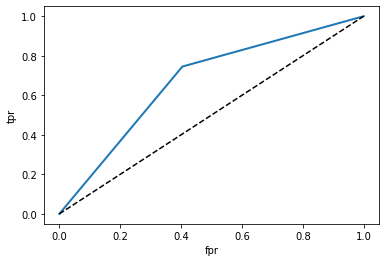

In [90]:
# ROC curve 만들기
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)

# ROC curve 시각화
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

### 3.4 Attempt with xgb model

In [69]:
# cv = 5로 변경
n_cv = 5
t1 = pd.Series(train_y.index.values, index=train_y.index)
# purged K-Fold
cv = PKFold(n_cv, t1, 0)

In [72]:
# xgb 모델 사용
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, KFold

xgb_params = {
    'n_estimators': [10, 15, 25],  # 더 많은 수의 트리 사용
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7], 
    'colsample_bytree': [0.5, 0.7],  
    'subsample': [0.7, 0.8, 1],  
            }
             

# XGBoost 분류기 인스턴스 생성
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# GridSearchCV를 사용하여 하이퍼파라미터 튜닝
gs_xgb = GridSearchCV(xgb_clf, xgb_params, cv=cv, n_jobs=-1, verbose=2)

# 학습 데이터로 모델 학습
gs_xgb.fit(train_x, train_y)

gs_xgb_best = gs_xgb.best_estimator_

Fitting 5 folds for each of 162 candidates, totalling 810 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7; total time=   5.1s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.7; total time=   6.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=10, subsample=0.8; total time=   5.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, subsample=0.7; total time=   7.8s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, subsample=0.8; total time=   8.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=15, subsample=1; total time=   8.4s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=25, subsample=0.7; total time=   2.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=25, subsample=0.8; total time=   3.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=25, s

In [73]:
gs_xgb_best.fit(train_x, train_y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=10, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [74]:
pred_y = gs_xgb_best.predict(test_x)
prob_y = gs_xgb_best.predict_proba(test_x)

In [75]:
confusion = confusion_matrix(test_y, pred_y)
accuracy  = accuracy_score(test_y, pred_y)
precision = precision_score(test_y, pred_y)
recall    = recall_score(test_y, pred_y)

print('================= confusion matrix ====================')
print(confusion)
print('=======================================================')
print(f'정확도:{accuracy}, 정밀도:{precision}, 재현율:{recall}')

================= confusion matrix ====================
[[79 57]
 [ 9 46]]
정확도:0.6544502617801047, 정밀도:0.44660194174757284, 재현율:0.8363636363636363


auc:0.7086229946524064


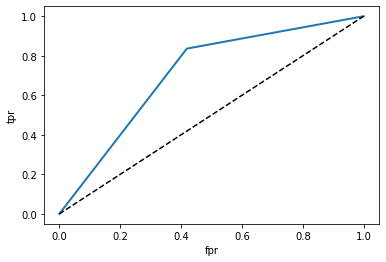

[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=15, subsample=0.7; total time=   7.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=15, subsample=0.8; total time=   8.2s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=15, subsample=0.8; total time=   7.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=15, subsample=1; total time=   8.1s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=25, subsample=0.8; total time=  12.9s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=3, n_estimators=25, subsample=1; total time=  14.7s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.7; total time=   9.6s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=5, n_estimators=10, subsample=0.

In [76]:
fpr, tpr, thresholds = roc_curve(test_y, pred_y)
auc = roc_auc_score(test_y, pred_y)
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
plt.xlabel('fpr')
plt.ylabel('tpr')
print(f'auc:{auc}')

# Retrospective

PKfold를 처음 사용해보았는데 시계열 데이터는 Data Leakage에 더 취약할 수 있다는 것을 알게 되었다.<br/>
지금까지 Kfold를 사용하며 Data Leakage는 크게 고려하지 않았는데, 추후에는 Data에 따라 Overfitting을 예방하기 위해 고려해야겠다고 느꼈다.<br/>
RandomForest Model이 앙상블 모델이기 때문에 BaggingClassifier를 함께 사용하여 분산을 줄이고,<br/> 
과적합을 방지하여 모델의 일반화 성능을 향상하는 방법도 인상적이었다.<br/>
다만 BaggingClassifier를 사용하지 않았을 때와 실제 성능은 큰 차이를 보이지 않았는데, 다른 데이터셋으로도 비교해봐야 할 것 같다.<br/>
<br/>
XGB Model이 가장 좋은 성능을 보였는데, 재현율이 6.98% 높았지만 정확도와 정밀도는 1~2% 차이로 미세하게 높아 큰 차이를 보이지 않았다.<br/>


<br/>
이전에 사용했던 ARIMA와는 다르게 상승, 하락을 맞추는 분류 모델이기 떄문에 결과물을 판단하기는 쉽지만 <br/>
주가를 예측하는 모델은 흐름을 예측하는 회귀 모델이 더 적합한 것 같다.<br/>
<br/>
아직은 어려운 개념들이 많아 이해 과정에서 시간이 오래 걸렸지만 <br/>
주식 그래프 모양은 모두 다르지만 그 속에는 사람들의 희노애락이 느껴져 주식 데이터로 예측을 진행하는 과정이 흥미로웠다. <br/>
주식뿐만 아니라 모든 데이터는 불규칙적인 다양한 영향을 받지만 호재, 악재를 판단하는 것은 사람이기 때문에 주식의 가격은 심리적인 요인이 많이 담겨있다고 생각한다.<br/>
주식을 예측한다는 것은 결국 사람을 예측하는 것이 아닐까 하는 생각이 들었다.<br/> 
언젠가 심리를 예측하는 모델이 완성된다면 주가 예측 모델도 완성되지 않을까?